In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go

In [2]:
data = pd.read_csv('/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv')
data.sample(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
3554,2020-07-09,297.810659,298.904022,288.805373,292.811035,5042800,0.0,0.0
1998,2014-05-05,69.865311,71.439930,69.617187,71.401756,4776900,0.0,0.0
1617,2012-10-24,44.065119,44.090719,42.951047,43.097061,7083000,0.0,0.0
209,2007-03-27,10.101992,10.101992,9.932320,9.998510,14708000,0.0,0.0
75,2006-09-12,5.673683,5.781594,5.673683,5.776942,16992000,0.0,0.0


# Análise de estátisticas - (DATA UNDERSTANDING)
* 1. Estátisticas básicas
* 2. Campos nulos
* 3. Dimensão
* 4. Correlação entre os dados


## Tipo de dado e amostra

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3872 entries, 0 to 3871
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3872 non-null   object 
 1   Open          3872 non-null   float64
 2   High          3872 non-null   float64
 3   Low           3872 non-null   float64
 4   Close         3872 non-null   float64
 5   Volume        3872 non-null   int64  
 6   Dividends     3872 non-null   float64
 7   Stock Splits  3872 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 242.1+ KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3872.0,1.048968e+02,1.062455e+02,3.748967,2.234720e+01,7.081008e+01,1.476884e+02,3.926539e+02
High,3872.0,1.059561e+02,1.073036e+02,4.102467,2.263800e+01,7.137590e+01,1.486454e+02,4.005215e+02
Low,3872.0,1.037693e+02,1.050501e+02,3.739664,2.203446e+01,7.022400e+01,1.468220e+02,3.897478e+02
Close,3872.0,1.048827e+02,1.061687e+02,4.083861,2.230039e+01,7.085608e+01,1.476884e+02,3.946857e+02
Volume,3872.0,1.232250e+07,1.759665e+07,641100.000000,3.529475e+06,5.891750e+06,1.319775e+07,3.953430e+08
Dividends,3872.0,2.329029e-03,2.585085e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e-01
Stock Splits,3872.0,2.582645e-03,1.607061e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01


## Dados em falta

In [5]:
data.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [6]:
data.isna().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

## Definir data como INDEX

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

#data = data.asfreq('D')
data = data.dropna()
# Verificando a frequência
print(data.index.freq)

None


In [8]:
data.index

DatetimeIndex(['2006-05-25', '2006-05-26', '2006-05-30', '2006-05-31',
               '2006-06-01', '2006-06-02', '2006-06-05', '2006-06-06',
               '2006-06-07', '2006-06-08',
               ...
               '2021-09-28', '2021-09-29', '2021-09-30', '2021-10-01',
               '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07',
               '2021-10-08', '2021-10-11'],
              dtype='datetime64[ns]', name='Date', length=3872, freq=None)

## Dimensionalidade e correlação

In [9]:
data.shape

(3872, 7)

<Axes: >

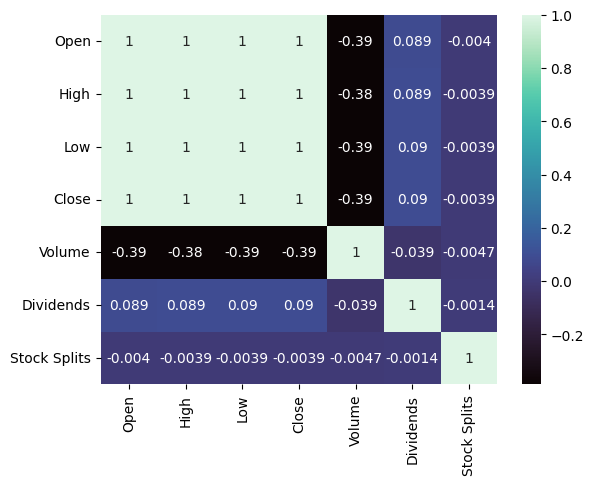

In [10]:
palette = sns.color_palette("mako", as_cmap=True)
corr = data.corr()

sns.heatmap(data=corr,cmap=palette,annot=True)

Existe correlação total entre Open,High,Low e Close

# Análise visual:
* 1. Teste ANOVA
* 2. Análise de tendência: média móvel, regressão, análise de decomposição, modelo ARIMA


## Teste anova

In [11]:
from scipy.stats import f_oneway


anova1 = f_oneway(data['Close'], data['Volume'], data['Stock Splits'], data['Dividends'])
anova2 = f_oneway(data['Close'], data['Open'], data['High'], data['Low'])

print("Estatística F (Variaveis com alta compatibilidade):", anova2.statistic)
print("Valor p:", anova2.pvalue)

print('\n')
print("Estatística F (Variaveis com baixa compatibilidade):", anova1.statistic)
print("Valor p:", anova1.pvalue)

Estatística F (Variaveis com alta compatibilidade): 0.27372092466418846
Valor p: 0.8443976304546679


Estatística F (Variaveis com baixa compatibilidade): 1898.762362151304
Valor p: 0.0


In [12]:
import pandas as pd
from itertools import combinations
from scipy.stats import f_oneway

resultado_anova = []
pares_de_colunas = combinations(data.columns, 2)
for par in pares_de_colunas:
    anova = f_oneway(data[par[0]], data[par[1]])
    resultado_anova.append({'Coluna 1': par[0], 'Coluna 2': par[1], 'Estatística F': anova.statistic, 'Valor p': anova.pvalue})
    
df_resultado = pd.DataFrame(resultado_anova)
df_resultado

,Coluna 1,Coluna 2,Estatística F,Valor p
0,Open,High,0.190523,0.662494
1,Open,Low,0.220484,0.638685
2,Open,Close,0.000034,0.995339
3,Open,Volume,1898.740810,0.000000
4,Open,Dividends,3774.152577,0.000000
5,Open,Stock Splits,3774.125915,0.000000
6,High,Low,0.821065,0.364897
7,High,Close,0.195769,0.658170
8,High,Volume,1898.740483,0.000000
9,High,Dividends,3775.194140,0.000000


## Análise de média móvel

Suavizar a os fechamentos mensais e verificar se há declinio ou aumento

In [13]:
from sklearn.linear_model import LinearRegression as lr

data['mediamovel'] = data['Dividends'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Dividends']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Dividends'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: dividendos',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig

In [14]:
from sklearn.linear_model import LinearRegression as lr

data['mediamovel'] = data['Close'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Close']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='Tendência pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: Fechamento',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig

In [15]:
from sklearn.linear_model import LinearRegression as lr

data['mediamovel'] = data['Volume'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Volume']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Volume'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='Tendência pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: Volume',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig

In [16]:
from sklearn.linear_model import LinearRegression as lr

data['mediamovel'] = data['Stock Splits'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Stock Splits']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Stock Splits'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='Tendência pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: Divisão de ações ',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig

## Análise de decomposição por adição

Análise de sazonalidade e tendência

In [17]:
import statsmodels.api as sm

new_data = data.copy()
new_data['Date'] = pd.to_datetime(new_data.index)
new_data.set_index('Date', inplace=True)
new_data = new_data.asfreq('ME')
new_data.fillna(new_data.mode().iloc[0], inplace=True)

decomposicao = sm.tsa.seasonal_decompose(pd.DataFrame(new_data['Close']), model='additive')

fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index,y=data.Close,mode='lines',name='Original'))
fig.add_trace(go.Scatter(x=decomposicao.trend.index,y=decomposicao.trend.values,mode='lines',name='Tendência'))
fig.add_trace(go.Scatter(x=decomposicao.seasonal.index,y=decomposicao.seasonal.values,mode='lines',name='Sazonalidade'))
fig.add_trace(go.Scatter(x=decomposicao.resid.index,y=decomposicao.resid.values,mode='lines',name='Residuo'))

fig.update_layout(title='Decomposição: Análise de tendência e sazonalidade: Modelo aditivo',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

fig

In [18]:
import statsmodels.api as sm

new_data = data.copy()
new_data['Date'] = pd.to_datetime(new_data.index)
new_data.set_index('Date', inplace=True)
new_data = new_data.asfreq('ME')
new_data.fillna(new_data.mode().iloc[0], inplace=True)

decomposicao = sm.tsa.seasonal_decompose(pd.DataFrame(new_data['Close']), model='multiplicative')

fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index,y=data.Close,mode='lines',name='Original'))
fig.add_trace(go.Scatter(x=decomposicao.trend.index,y=decomposicao.trend.values,mode='lines',name='Tendência'))
fig.add_trace(go.Scatter(x=decomposicao.seasonal.index,y=decomposicao.seasonal.values,mode='lines',name='Sazonalidade'))
fig.add_trace(go.Scatter(x=decomposicao.resid.index,y=decomposicao.resid.values,mode='lines',name='Residuo'))

fig.update_layout(title='Decomposição: Análise de tendência e sazonalidade: modelo multiplicativo',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

fig
